In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import time

n_workers = "4"

spark_session = SparkSession.builder\
        .master("spark://192.168.2.145:7077") \
        .appName("TEST")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.dynamicAllocation.minExecutors", n_workers)\
        .config("spark.dynamicAllocation.maxExecutors", n_workers)\
        .config("spark.driver.port",9999)\
        .config("spark.blockManager.port",10005)\
        .getOrCreate()

# RDD API
spark_context = spark_session.sparkContext

spark_context.setLogLevel("WARN")

# Assuming you have a file to read in HDFS
#lines = spark_context.textFile("hdfs://192.168.2.145:5000/de11project/test2.txt")
#print(lines.first())

#spark_context.stop()

#hdfs_path = 'hdfs://192.168.2.145:5000/de11project/aggregated_song_features_2.csv'

# Read the H5 file into a DataFrame


# Show the DataFrame schema


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/10 11:31:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/03/10 11:31:06 WARN StandaloneSchedulerBackend: Dynamic allocation enabled without spark.executor.cores explicitly set, you may get more executors allocated than expected. It's recommended to set spark.executor.cores explicitly. Please check SPARK-30299 for more details.
24/03/10 11:31:06 WARN Utils: spark.executor.instances less than spark.dynamicAllocation.minExecutors is invalid, ignoring its setting, please update your configs.


In [2]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import abs
from pyspark.sql.types import FloatType

def get_bpm_range(bpm_diff):
    if bpm_diff < 10:
        return 0.6
    elif bpm_diff < 20:
        return 0.4
    elif bpm_diff < 30:
        return 0.3
    elif bpm_diff < 40:
        return 0.1
    else:
        return 0.0

def get_loudness_range(loudness_diff):
    if loudness_diff < 2:
        return 0.4
    elif loudness_diff < 15:
        return 0.3
    elif loudness_diff < 35:
        return 0.2
    elif loudness_diff < 40:
        return 0.1
    else:
        return 0.0

get_bpm_range_udf = udf(get_bpm_range, FloatType())
get_loudness_range_udf = udf(get_loudness_range, FloatType())

def calculate_danceability(loudness_col, bpm_col):
    # Applying transformations to DataFrame columns
    loudness_col = abs(loudness_col + 7)
    bpm_col = abs(bpm_col - 120)
    
    # Apply UDFs to DataFrame columns
    loudness_score = get_loudness_range_udf(loudness_col)
    bpm_score = get_bpm_range_udf(bpm_col)
    
    # Calculate danceability
    danceability = bpm_score + loudness_score

    return danceability


# Define UDF for year_to_decade function
def year_to_decade_udf(year):
    return year - (year % 10)

year_to_decade_spark_udf = udf(year_to_decade_udf, IntegerType())

def prune_data(df):
    # Remove rows with missing values
    df = df.dropna()
    # Remove rows with invalid values
    df = df.filter((col('year') > 0) & (col('year') < 2024) &
                   (col('bpm') > 0) & (col('bpm') < 300) &
                   (col('loudness') > -100) & (col('loudness') < 0))
    return df

def preprocess_data(df, check_year):
    print('in prepr', df, check_year)
    # Calculate danceability
    df = df.withColumn('year', col('year').cast(IntegerType()))
    df = df.withColumn('loudness', col('loudness').cast(IntegerType()))
    df = df.withColumn('bpm', col('bpm').cast(IntegerType()))
    new_df = prune_data(df)
    new_df = new_df.withColumn('danceability', calculate_danceability(col('loudness'), col('bpm')))
    new_df = new_df.withColumn('danceability', col('danceability').cast(IntegerType()))
    # Prune the data
    new_df = new_df.withColumn('decade', year_to_decade_spark_udf(col('year')))
    new_df = new_df.drop('loudness', 'bpm', 'year')
    return new_df

print('went ok :)')


went ok :)


In [3]:
from pyspark.sql.functions import round, count, avg

start = time.time()
file_path = 'hdfs://192.168.2.145:5000/de11project/aggregated_song_features_1000x-2.csv'  # Replace this with the actual file path

# Read the CSV file into a DataFrame, using the first row as headers
spark_df = spark_session.read.format("csv")\
    .option("header", "true")\
    .load(file_path)

spark_df.show()

num_rows = spark_df.count()

# Get the number of columns
num_columns = len(spark_df.columns)

print("Number of Rows:", num_rows)
print("Number of Columns:", num_columns)

preprocessed_df = preprocess_data(spark_df, check_year=True)

num_columns = len(preprocessed_df.columns)
num_rows = preprocessed_df.count()

print("Number of Rows:", num_rows)
print("Number of Columns:", num_columns)

grouped_decade = preprocessed_df.groupBy('decade')\
    .agg(
        round(avg('danceability'), 2).alias('mean_danceability'),
        count('*').alias('count')
    )

# Show the result
grouped_decade.show()

+-------+-------------------+----+
|    bpm|           loudness|year|
+-------+-------------------+----+
| 98.198| -5.196999999999999|   0|
|127.274|             -3.843|1975|
| 106.07|             -3.689|   0|
|125.293|             -3.013|1988|
|135.738|               -5.0|2013|
|153.782|-3.3230000000000004|   0|
|117.787|            -11.302|   0|
| 107.43|-5.6419999999999995|   0|
| 92.643|             -7.496|1990|
|120.041|-0.6970000000000001|   0|
|152.765| -4.021000000000001|   0|
|123.975|             -1.545|   0|
| 136.04|-0.6319999999999997|   0|
|143.334|              -1.75|   0|
|131.197|             -2.346|1992|
|125.826|-2.5760000000000005|1993|
|133.756|             -10.11|   0|
|105.273|             -2.032|   0|
|156.062|              -14.0|2010|
|144.331|-0.7869999999999999|   0|
+-------+-------------------+----+
only showing top 20 rows



Number of Rows: 10000000
Number of Columns: 3
in prepr DataFrame[bpm: string, loudness: string, year: string] True


Number of Rows: 1803109
Number of Columns: 2


+------+-----------------+------+
|decade|mean_danceability| count|
+------+-----------------+------+
|  1990|             0.02|179306|
|  1950|             0.04|  6207|
|  2020|             0.02|466412|
|  1960|             0.03|  6907|
|  1970|             0.03| 15275|
|  1980|             0.02| 64648|
|  2000|             0.02|339083|
|  2010|             0.02|723663|
|  1940|             0.04|  1316|
|  1930|             0.18|   292|
+------+-----------------+------+



hej2
Number of Rows: 10000000
Number of Columns: 3
in prepr DataFrame[bpm: string, loudness: string, year: string] True


Number of Rows: 1803109
Number of Columns: 2


+------+----+------+
|decade|mean| count|
+------+----+------+
|  1990|0.02|179306|
|  1930|0.18|   292|
|  1950|0.04|  6207|
|  2020|0.02|466412|
|  1960|0.03|  6907|
|  1970|0.03| 15275|
|  1980|0.02| 64648|
|  2000|0.02|339083|
|  2010|0.02|723663|
|  1940|0.04|  1316|
+------+----+------+



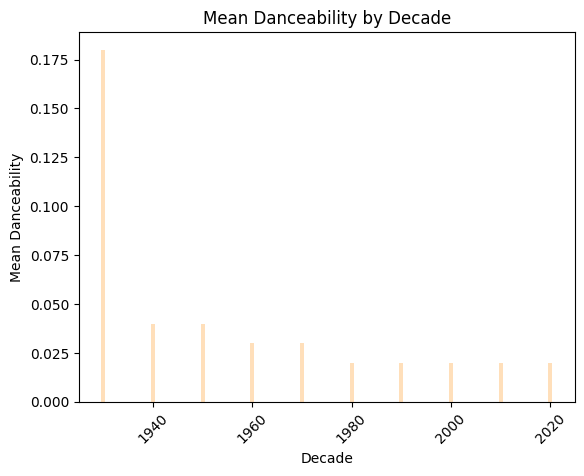

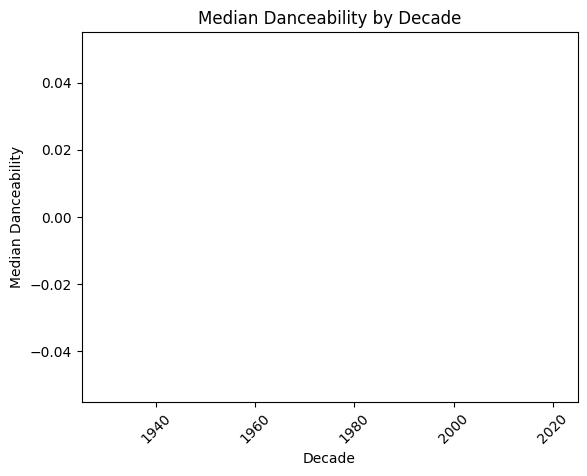

+--------------------+-------+
|rounded_danceability|  count|
+--------------------+-------+
|                   0|1769279|
|                   1|  33830|
+--------------------+-------+



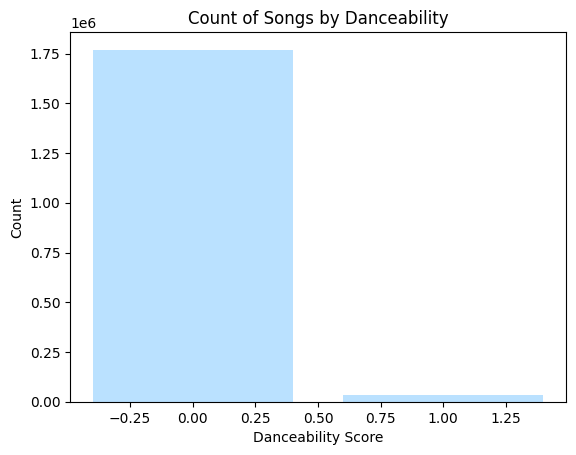

Time elapsed with 4 workers: 68.30691981315613


In [4]:
import matplotlib.pyplot as plt

print("hej2")

num_rows = spark_df.count()

# Get the number of columns
num_columns = len(spark_df.columns)

print("Number of Rows:", num_rows)
print("Number of Columns:", num_columns)

preprocessed_df = preprocess_data(spark_df, check_year=True)

num_columns = len(preprocessed_df.columns)
num_rows = preprocessed_df.count()

print("Number of Rows:", num_rows)
print("Number of Columns:", num_columns)

grouped_decade = preprocessed_df.groupBy('decade')\
    .agg({'danceability': 'mean', '*': 'count'})\
    .withColumnRenamed('count(1)', 'count')\
    .withColumn('mean', round('avg(danceability)', 2))\
    .select('decade', 'mean', 'count')

# Show the result
grouped_decade.show()

#grouped_decade.write.csv('../data/mean_danceability_by_decade.csv', header=True) #became a folder? look up later


decades = grouped_decade.select('decade').rdd.flatMap(lambda x: x).collect()
mean_danceability = grouped_decade.select('mean').rdd.flatMap(lambda x: x).collect()

# Plotting
plt.bar(decades, mean_danceability, color='#ffdfba', linewidth=2.5)
plt.xticks(rotation=45)
plt.ylabel('Mean Danceability')
plt.xlabel('Decade')
plt.title('Mean Danceability by Decade')
plt.savefig('../images/mean_danceability_by_decade.png', bbox_inches='tight')
plt.show()


grouped_decade_median = preprocessed_df.groupBy('decade')\
    .agg({'danceability': 'median'})\
    .withColumnRenamed('median(danceability)', 'median_danceability')\
    .select('decade', 'median_danceability')\
    .withColumn('median_danceability', round('median_danceability', 2))

decades = grouped_decade_median.select('decade').rdd.flatMap(lambda x: x).collect()
median_danceability = grouped_decade_median.select('median_danceability').rdd.flatMap(lambda x: x).collect()

# Plotting
plt.bar(decades, median_danceability, color='#ffb3ba')
plt.xticks(rotation=45)
plt.ylabel('Median Danceability')
plt.xlabel('Decade')
plt.title('Median Danceability by Decade')
plt.savefig('../images/median_danceability_by_decade.png', bbox_inches='tight')
plt.show()


# Round danceability column to two decimal places
preprocessed_df_rounded = preprocessed_df.withColumn('rounded_danceability', round('danceability', 2))

# Group by rounded danceability scores and count the number of songs for each score
danceability_score_count = preprocessed_df_rounded.groupBy('rounded_danceability').count().orderBy('rounded_danceability')

# Show the result
danceability_score_count.show()

# Collect data to driver node
scores = danceability_score_count.select('rounded_danceability').rdd.flatMap(lambda x: x).collect()
counts = danceability_score_count.select('count').rdd.flatMap(lambda x: x).collect()

# Plotting
plt.bar(scores, counts, color='#bae1ff') #too thick!! Change later
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.xlabel('Danceability Score')
plt.title('Count of Songs by Danceability')
plt.savefig('../images/count_of_songs_by_danceability.png', bbox_inches='tight')
plt.show()
end = time.time()
print(f"Time elapsed with {n_workers} workers: {end - start}")
 
spark_session.stop()